In [31]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [32]:
accidents = pd.read_csv('/kaggle/input/us-accidents/US_Accidents_Dec21_updated.csv')


In [33]:
accidents.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2845342 entries, 0 to 2845341
Data columns (total 47 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   ID                     object 
 1   Severity               int64  
 2   Start_Time             object 
 3   End_Time               object 
 4   Start_Lat              float64
 5   Start_Lng              float64
 6   End_Lat                float64
 7   End_Lng                float64
 8   Distance(mi)           float64
 9   Description            object 
 10  Number                 float64
 11  Street                 object 
 12  Side                   object 
 13  City                   object 
 14  County                 object 
 15  State                  object 
 16  Zipcode                object 
 17  Country                object 
 18  Timezone               object 
 19  Airport_Code           object 
 20  Weather_Timestamp      object 
 21  Temperature(F)         float64
 22  Wind_Chill(F)     

# Data Cleaning/Processing
**1. Handling missing values**

Here, we will remove any incorrect or missing values from the dataset. Action on Side column:

In [72]:
#Take care of incorrect and missing values

accidents = accidents.drop(accidents[accidents.Side == 'N'].index)
accidents["Side"].value_counts()

R    525662
L    412878
Name: Side, dtype: int64

Here we observed that there is one row without side value as R/L therefore we can drop it.

Also dropped ID and Description column as they are not providing information on the accident which can be feeded into the models in the future.

In [35]:
accidents.drop(['ID', 'Description'], axis=1, inplace=True)
pd.set_option('display.max_columns', 500)
accidents.sample(3)

,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Number,Street,Side,City,County,State,Zipcode,Country,Timezone,Airport_Code,Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
843144,2,2021-12-01 18:17:44.000000000,2021-12-01 19:36:56.000000000,40.163528,-75.154107,40.164710,-75.152401,0.122,1899.0,Jarrettown Rd,R,Dresher,Montgomery,PA,19025-1301,US,US/Eastern,KLOM,2021-12-01 18:15:00,38.0,38.0,74.0,29.81,10.0,CALM,0.0,0.0,Cloudy,False,False,False,False,False,False,False,False,False,False,False,True,False,Night,Night,Night,Night
950024,2,2021-09-12 11:24:00.000000,2021-09-12 12:42:16.000000,34.135565,-117.992628,34.135571,-117.995167,0.145,NaN,Foothill Fwy W,R,Monrovia,Los Angeles,CA,91016,US,US/Pacific,KEMT,2021-09-12 11:53:00,88.0,88.0,37.0,29.81,10.0,VAR,5.0,0.0,Fair,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day
2691147,2,2018-02-15 08:09:18,2018-02-15 14:09:18,42.514460,-71.024060,42.513860,-71.028770,0.243,NaN,MA-128 S,R,Lynnfield,Essex,MA,01940,US,US/Eastern,KBVY,2018-02-15 07:53:00,34.0,NaN,96.0,29.90,6.0,Calm,NaN,NaN,Overcast,False,False,False,False,True,False,False,False,False,False,False,False,False,Day,Day,Day,Day


**2. Handling data with a high cardinality**



In [36]:
print(accidents.Weather_Condition.unique())


['Light Rain' 'Overcast' 'Mostly Cloudy' 'Snow' 'Light Snow' 'Cloudy' nan
 'Scattered Clouds' 'Clear' 'Partly Cloudy' 'Light Freezing Drizzle'
 'Light Drizzle' 'Haze' 'Rain' 'Heavy Rain' 'Fair' 'Drizzle' 'Fog'
 'Thunderstorms and Rain' 'Patches of Fog' 'Light Thunderstorms and Rain'
 'Mist' 'Rain Showers' 'Light Rain Showers' 'Heavy Drizzle' 'Smoke'
 'Light Freezing Fog' 'Light Freezing Rain' 'Blowing Snow'
 'Heavy Thunderstorms and Rain' 'Heavy Snow' 'Snow Grains' 'Squalls'
 'Light Fog' 'Shallow Fog' 'Thunderstorm' 'Light Ice Pellets' 'Thunder'
 'Thunder in the Vicinity' 'Fair / Windy' 'Light Rain with Thunder'
 'Heavy Thunderstorms and Snow' 'Light Snow Showers' 'Cloudy / Windy'
 'Ice Pellets' 'N/A Precipitation' 'Light Thunderstorms and Snow'
 'T-Storm' 'Rain / Windy' 'Wintry Mix' 'Partly Cloudy / Windy'
 'Heavy T-Storm' 'Sand' 'Light Rain / Windy' 'Widespread Dust'
 'Mostly Cloudy / Windy' 'Blowing Dust / Windy' 'Blowing Dust'
 'Volcanic Ash' 'Freezing Rain / Windy' 'Small Hail' 'W

Data can be combined or binned. By assembling them into coherent sets, the goal is to lower the number of unique values. As long as the groupings do not significantly affect model performance and business stakeholder explainability, this approach is excellent.

In [37]:
accidents.loc[accidents["Weather_Condition"].str.contains("N/A Precipitation", na=False), "Weather_Condition"] = np.nan
accidents.loc[accidents["Weather_Condition"].str.contains("Snow|Sleet|Wintry", na=False), "Weather_Condition"] = "Snow"
accidents.loc[accidents["Weather_Condition"].str.contains("Smoke|Volcanic Ash", na=False), "Weather_Condition"] = "Smoke"
accidents.loc[accidents["Weather_Condition"].str.contains("Cloud|Overcast", na=False), "Weather_Condition"] = "Cloudy"
accidents.loc[accidents["Weather_Condition"].str.contains("Sand|Dust", na=False), "Weather_Condition"] = "Sand"
accidents.loc[accidents["Weather_Condition"].str.contains("Wind|Squalls", na=False), "Weather_Condition"] = "Windy"
accidents.loc[accidents["Weather_Condition"].str.contains("Mist|Haze|Fog", na=False), "Weather_Condition"] = "Fog"
accidents.loc[accidents["Weather_Condition"].str.contains("Thunder|T-Storm", na=False), "Weather_Condition"] = "Thunderstorm"
accidents.loc[accidents["Weather_Condition"].str.contains("Rain|Drizzle|Shower", na=False), "Weather_Condition"] = "Rain"
accidents.loc[accidents["Weather_Condition"].str.contains("Hail|Pellets", na=False), "Weather_Condition"] = "Hail"
accidents.loc[accidents["Weather_Condition"].str.contains("Fair", na=False), "Weather_Condition"] = "Clear"

print('Unique values:',accidents["Weather_Condition"].unique())

Unique values: ['Rain' 'Cloudy' 'Snow' nan 'Clear' 'Fog' 'Thunderstorm' 'Smoke' 'Windy'
 'Hail' 'Sand' 'Tornado']


**3. One-hot Encoding** 

We converted bool values to 0s and 1s as will be easier to feed the models we make in phase2.

In [1]:
#One-hot Encoding 

accidents = accidents.replace([True, False], [1,0])
accidents.info()

NameError: name 'accidents' is not defined

**4. Remove Duplicate Data**

We did not have any duplicates but this was fail safe cleaning as Duplicate data sets have the potential to contaminate the training data with the test data, or the other way around. This can make the model bias towards one feature.

In [39]:
Duplicate_Data = accidents[accidents.duplicated()]
print("Duplicate Rows :{}".format(Duplicate_Data))
accidents.drop_duplicates(inplace=True)


Duplicate Rows :         Severity           Start_Time             End_Time  Start_Lat  \
650             4  2016-03-04 00:48:56  2016-03-04 06:48:56  39.781457   
993             2  2016-03-22 21:36:42  2016-03-23 03:36:42  38.518811   
1194            2  2016-03-28 14:01:03  2016-03-28 20:01:03  38.539453   
2428            2  2016-04-22 14:20:01  2016-04-22 20:20:01  37.861551   
2857            2  2016-05-02 15:31:50  2016-05-02 21:31:50  38.254460   
...           ...                  ...                  ...        ...   
2843257         2  2019-08-19 14:13:50  2019-08-19 14:43:33  38.554710   
2843449         4  2019-08-20 17:41:30  2019-08-20 18:10:03  35.670880   
2843938         2  2019-08-21 16:09:27  2019-08-21 16:35:16  36.035200   
2844521         4  2019-08-22 18:01:59  2019-08-22 18:29:54  35.917747   
2844523         4  2019-08-22 18:01:59  2019-08-22 18:29:54  35.941291   

          Start_Lng    End_Lat     End_Lng  Distance(mi)   Number  \
650      -85.839651  39.78

**5. NA value handling (Imputation by mean value)**

Since filling them with zero doesn't make much sense, we populated the following columns with their average value.

In [40]:
accidents['Wind_Speed(mph)']=accidents['Wind_Speed(mph)'].fillna(accidents['Wind_Speed(mph)'].mean())
accidents['Humidity(%)']=accidents['Humidity(%)'].fillna(accidents['Humidity(%)'].mean())
accidents['Temperature(F)']=accidents['Temperature(F)'].fillna(accidents['Temperature(F)'].mean())
accidents['Pressure(in)']=accidents['Pressure(in)'].fillna(accidents['Pressure(in)'].mean())
accidents.dropna(inplace=True)

**6. NA value handling (Imputation by median value)**

When the data is skewed, it is wise to think about replacing the missing values with the median value. Keep in mind that only numerical data can be used to impute missing data using the median value. Because it lessens the impact of outliers, using the median to impute is more reliable.

In [74]:
#NA value handling (Imputation by median value)

accidents['Visibility(mi)']=accidents['Visibility(mi)'].fillna(accidents['Visibility(mi)'].median())
accidents['Wind_Chill(F)']=accidents['Wind_Chill(F)'].fillna(accidents['Wind_Chill(F)'].median())
accidents['Precipitation(in)']=accidents['Precipitation(in)'].fillna(accidents['Precipitation(in)'].median())
accidents.dropna(inplace=True)

**7. Impute empty value with most occurring value (or mode)**

The mode value, or most frequent value, of the full feature column is substituted for the missing values in mode imputation, a further approach. It is wise to think about utilizing mode values to replace missing values when the data is skewed. You might think about substituting values for data points like the city field with mode. It should be noted that both numerical and categorical data can be used to impute missing data using mode values.

In [42]:
#Impute empty value with most occurring value (or mode)

accidents['City'] = accidents.groupby('State')['City'].transform(lambda data: data.fillna(data.value_counts().index[0]))

**8. Scaling of feature**

We will scale and normalize the characteristics in this part. We normalized the values of the continuous features to enhance the performance of our models.

In [75]:
#Scaling of feature

ss = MinMaxScaler()
attributes = ['Wind_Speed(mph)','Pressure(in)','Humidity(%)','Distance(mi)','Visibility(mi)','Temperature(F)']
accidents[attributes] = ss.fit_transform(accidents[attributes])
accidents.sample(3)

,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Number,Street,Side,City,County,State,Zipcode,Country,Timezone,Airport_Code,Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,M,Y,D,H
1703318,2,2021-01-11 20:39:00,2021-01-11 22:40:41,33.022305,-117.221519,33.022409,-117.220148,0.000708,5200.0,Avenida Maravillas,L,Rancho Santa Fe,San Diego,CA,92067,US,US/Pacific,KCRQ,2021-01-11 20:53:00,0.501754,54.0,0.424242,0.316120,0.1,E,0.00276,0.0,Clear,0,0,0,0,0,0,0,0,0,1,0,0,0,Night,Night,Night,Night,01,2021,1,20
1268354,2,2021-08-31 15:19:49.000000000,2021-08-31 16:35:56.000000000,25.748011,-80.331510,25.748159,-80.331521,0.000089,8399.0,Coral Way,L,Miami,Miami-Dade,FL,33155-1138,US,US/Eastern,KMIA,2021-08-31 14:53:00,0.610526,85.0,0.646465,0.318050,0.1,SSE,0.01104,0.0,Thunderstorm,0,0,1,0,0,0,0,0,0,0,0,1,0,Day,Day,Day,Day,08,2021,2,15
428945,2,2021-10-06 18:09:51.000000000,2021-10-06 20:11:42.000000000,25.862974,-80.242262,25.868198,-80.243538,0.003275,9719.0,NW 27th Ave,L,Miami,Miami-Dade,FL,33147-2153,US,US/Eastern,KOPF,2021-10-06 17:53:00,0.610526,85.0,0.666667,0.320463,0.1,ESE,0.00736,0.0,Clear,0,0,0,0,0,0,0,0,1,0,0,0,0,Day,Day,Day,Day,10,2021,3,18


**9. Adding of feature**

We made the decision to divide the Start Time feature (so that we can feed it to the model later) into the following components: year, month, day, weekday, hour, and minute.

In [44]:
accidents['M'] = pd.to_datetime(accidents.Start_Time).dt.strftime('%m')
accidents['Y'] =  pd.to_datetime(accidents.Start_Time).dt.strftime('%Y')
accidents['D'] = pd.to_datetime(accidents.Start_Time).dt.strftime('%w')
accidents['H'] = pd.to_datetime(accidents.Start_Time).dt.strftime("%H")
accidents.sample(2)

,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Number,Street,Side,City,County,State,Zipcode,Country,Timezone,Airport_Code,Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,M,Y,D,H
805525,2,2021-07-19 22:43:21,2021-07-20 01:03:05,36.069955,-86.634021,36.069213,-86.633191,0.000611,2723.0,Murfreesboro Pike,R,Antioch,Davidson,TN,37013-2003,US,US/Central,KBNA,2021-07-19 22:53:00,0.585965,78.0,0.656566,0.305261,0.1,E,0.00276,0.0,Cloudy,0,0,0,0,0,0,0,0,0,0,0,0,0,Night,Night,Night,Night,07,2021,1,22
718014,2,2021-08-27 17:31:26,2021-08-27 18:11:27,26.101947,-80.260149,26.103198,-80.265274,0.002921,8549.0,W State Road 84,L,Fort Lauderdale,Broward,FL,33324,US,US/Eastern,KHWO,2021-08-27 17:53:00,0.614035,86.0,0.666667,0.319739,0.1,E,0.01104,0.0,Cloudy,0,0,0,0,0,0,0,0,0,0,0,0,0,Day,Day,Day,Day,08,2021,5,17


**10. Examine feature variance**

This part will examine each feature's variance in order to eliminate features with very low variances because they cannot aid in instance discrimination.

In [45]:
pd.set_option('display.max_columns', None)
accidents.describe()
accidents.round(2)

,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Number,Street,Side,City,County,State,Zipcode,Country,Timezone,Airport_Code,Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,M,Y,D,H
42,4,2016-02-09 18:20:58,2016-02-10 00:20:58,40.45,-85.15,40.35,-85.15,0.06,9001.0,W State Road 26,R,Dunkirk,Jay,IN,47336,US,US/Eastern,KMIE,2016-02-09 18:20:00,0.38,7.3,0.81,0.32,0.02,WNW,0.01,0.00,Snow,0,0,0,0,0,0,0,0,0,0,0,0,0,Night,Day,Day,Day,02,2016,2,18
43,4,2016-02-09 18:20:58,2016-02-10 00:20:58,40.35,-85.15,40.45,-85.15,0.06,473.0,N Meridian St,R,Redkey,Jay,IN,47373-9430,US,US/Eastern,KMIE,2016-02-09 18:20:00,0.38,7.3,0.81,0.32,0.02,WNW,0.01,0.00,Snow,0,0,0,0,0,0,0,0,0,0,0,0,0,Night,Day,Day,Day,02,2016,2,18
47,4,2016-02-10 06:18:49,2016-02-10 12:18:49,40.73,-84.79,40.75,-84.79,0.01,12998.0,State Route 49,R,Willshire,Van Wert,OH,45898-9523,US,US/Eastern,KFWA,2016-02-10 05:54:00,0.37,0.6,0.77,0.32,0.02,West,0.02,0.01,Snow,0,0,0,0,0,0,0,0,0,0,0,0,0,Night,Night,Night,Day,02,2016,3,06
50,2,2016-02-10 08:35:27,2016-02-10 14:35:27,41.83,-80.10,41.84,-80.11,0.01,25529.0,Highway 99,L,Cambridge Springs,Crawford,PA,16403,US,US/Eastern,KGKJ,2016-02-10 08:34:00,0.39,9.9,0.85,0.31,0.01,WSW,0.01,0.00,Snow,0,0,0,0,0,0,0,0,0,0,0,0,0,Day,Day,Day,Day,02,2016,3,08
66,2,2016-02-10 12:54:39,2016-02-10 18:54:39,41.48,-81.66,41.48,-81.66,0.00,3937.0,Iron Ct,L,Cleveland,Cuyahoga,OH,44115,US,US/Eastern,KBKL,2016-02-10 12:53:00,0.40,7.1,0.75,0.32,0.02,West,0.03,0.00,Snow,0,0,0,0,0,0,0,0,0,0,0,0,0,Day,Day,Day,Day,02,2016,3,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2845298,3,2019-08-23 16:19:21,2019-08-23 16:48:04,37.61,-122.49,37.61,-122.50,0.00,895.0,San Marlo Way,R,Pacifica,San Mateo,CA,94044,US,US/Pacific,KSFO,2019-08-23 15:56:00,0.59,78.0,0.54,0.31,0.10,NNE,0.01,0.00,Clear,0,0,0,0,0,0,0,0,0,0,0,0,0,Day,Day,Day,Day,08,2019,5,16
2845302,4,2019-08-23 17:25:12,2019-08-23 17:54:00,39.00,-121.67,39.00,-121.66,0.01,3044.0,Thompson Rd,R,Yuba City,Sutter,CA,95993-9744,US,US/Pacific,KMYV,2019-08-23 17:53:00,0.66,98.0,0.22,0.31,0.10,S,0.01,0.00,Cloudy,0,0,0,0,0,0,0,0,0,0,0,0,0,Day,Day,Day,Day,08,2019,5,17
2845303,4,2019-08-23 17:25:12,2019-08-23 17:54:00,39.00,-121.66,39.00,-121.67,0.01,2500.0,Tudor Rd,R,Yuba City,Sutter,CA,95993-9513,US,US/Pacific,KMYV,2019-08-23 17:53:00,0.66,98.0,0.22,0.31,0.10,S,0.01,0.00,Cloudy,0,0,0,0,0,0,0,0,0,0,0,0,0,Day,Day,Day,Day,08,2019,5,17
2845304,3,2019-08-23 01:16:01,2019-08-23 01:44:53,34.12,-117.25,34.12,-117.25,0.00,1498.0,E Base Line St,L,San Bernardino,San Bernardino,CA,92410-4114,US,US/Pacific,KSBD,2019-08-23 01:20:00,0.55,67.0,0.73,0.29,0.10,W,0.00,0.00,Clear,0,0,0,0,0,0,0,0,0,0,0,0,0,Night,Night,Night,Night,08,2019,5,01


In [76]:
#filling all the null values in the below attributes 
features_to_fill = ["Temperature(F)", "Humidity(%)", "Pressure(in)", "Visibility(mi)", "Wind_Speed(mph)", "Precipitation(in)"]
accidents[features_to_fill] = accidents[features_to_fill].fillna(accidents[features_to_fill].mean())

accidents.dropna(inplace=True)

accidents.isna().sum()

Severity                 0
Start_Time               0
End_Time                 0
Start_Lat                0
Start_Lng                0
End_Lat                  0
End_Lng                  0
Distance(mi)             0
Number                   0
Street                   0
Side                     0
City                     0
County                   0
State                    0
Zipcode                  0
Country                  0
Timezone                 0
Airport_Code             0
Weather_Timestamp        0
Temperature(F)           0
Wind_Chill(F)            0
Humidity(%)              0
Pressure(in)             0
Visibility(mi)           0
Wind_Direction           0
Wind_Speed(mph)          0
Precipitation(in)        0
Weather_Condition        0
Amenity                  0
Bump                     0
Crossing                 0
Give_Way                 0
Junction                 0
No_Exit                  0
Railway                  0
Roundabout               0
Station                  0
S

<AxesSubplot:title={'center':'Traffic_Signal'}>

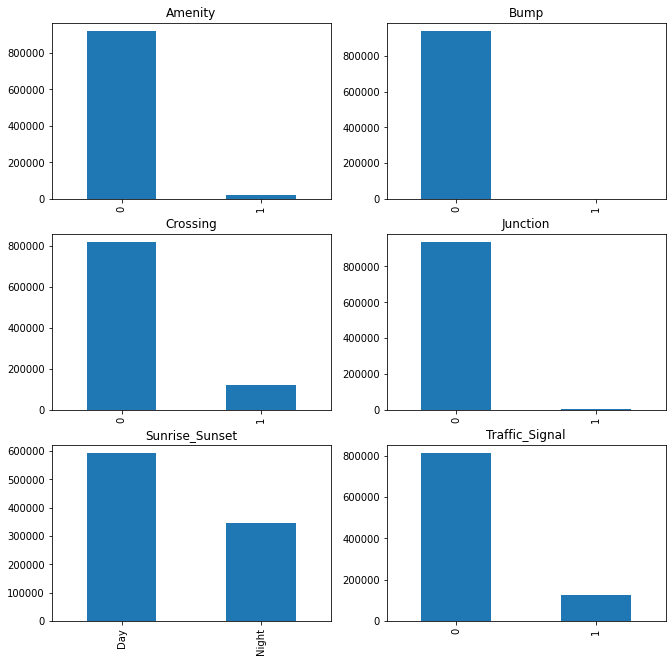

In [77]:
#Plot for bool feature attributes
fig = plt.figure(figsize=(11,11)) 
fig_dims = (3, 2)


plt.subplot2grid(fig_dims, (0, 0))
accidents['Amenity'].value_counts().plot(kind='bar', 
                                     title='Amenity')
plt.subplot2grid(fig_dims, (0, 1))
accidents['Bump'].value_counts().plot(kind='bar', 
                                     title='Bump')
plt.subplot2grid(fig_dims, (1, 0))
accidents['Crossing'].value_counts().plot(kind='bar', 
                                     title='Crossing')
plt.subplot2grid(fig_dims, (1, 1))
accidents['Junction'].value_counts().plot(kind='bar', 
                                     title='Junction')
plt.subplot2grid(fig_dims, (2, 0))
accidents['Sunrise_Sunset'].value_counts().plot(kind='bar', 
                                     title='Sunrise_Sunset')
plt.subplot2grid(fig_dims, (2, 1))
accidents['Traffic_Signal'].value_counts().plot(kind='bar', 
                                     title='Traffic_Signal')

<AxesSubplot:title={'center':'Stop'}>

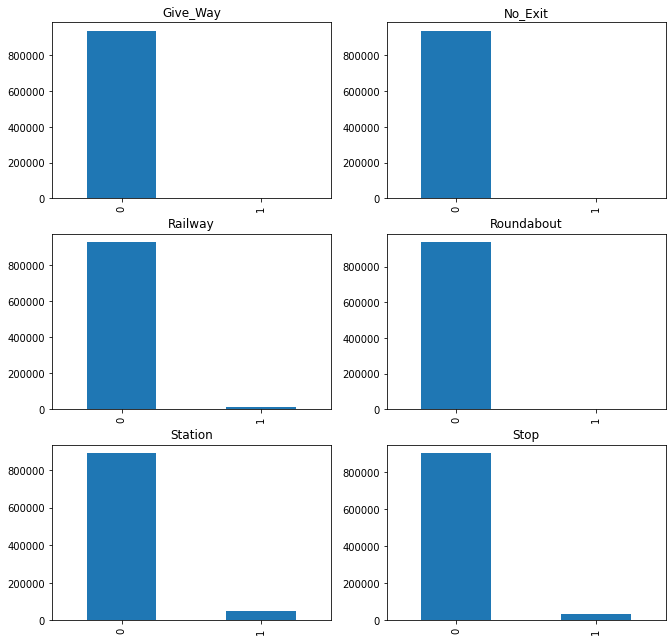

In [78]:
#plot for bool feature attributes
fig = plt.figure(figsize=(11,11)) 
fig_dims = (3, 2)


plt.subplot2grid(fig_dims, (0, 0))
accidents['Give_Way'].value_counts().plot(kind='bar', 
                                     title='Give_Way')
plt.subplot2grid(fig_dims, (0, 1))
accidents['No_Exit'].value_counts().plot(kind='bar', 
                                     title='No_Exit')
plt.subplot2grid(fig_dims, (1, 0))
accidents['Railway'].value_counts().plot(kind='bar', 
                                     title='Railway')
plt.subplot2grid(fig_dims, (1, 1))
accidents['Roundabout'].value_counts().plot(kind='bar', 
                                     title='Roundabout')
plt.subplot2grid(fig_dims, (2, 0))
accidents['Station'].value_counts().plot(kind='bar', 
                                     title='Station')
plt.subplot2grid(fig_dims, (2, 1))
accidents['Stop'].value_counts().plot(kind='bar', 
                                     title='Stop')

In [49]:
accidents["Bump"].value_counts()

0    937855
1       685
Name: Bump, dtype: int64

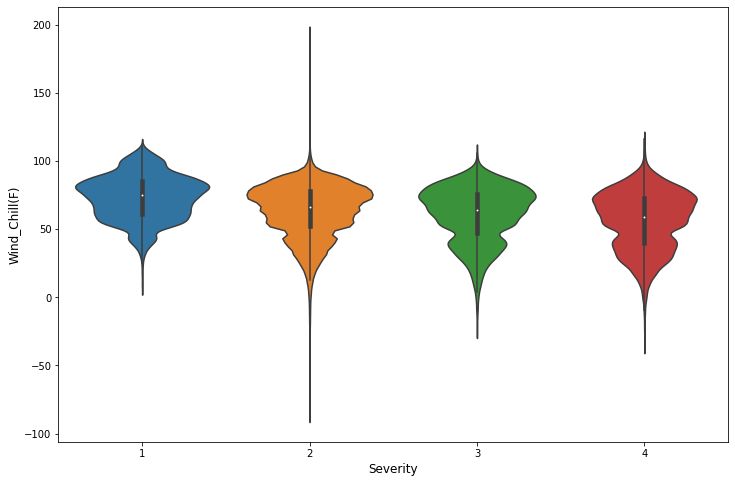

In [79]:
#voilin plot to study the distribution of the data
import seaborn as sns 


plt.figure(figsize=(12,8))
sns.violinplot(x='Severity', y='Wind_Chill(F)', data=accidents)
plt.xlabel('Severity', fontsize=12)
plt.ylabel('Wind_Chill(F)', fontsize=12)
plt.show()

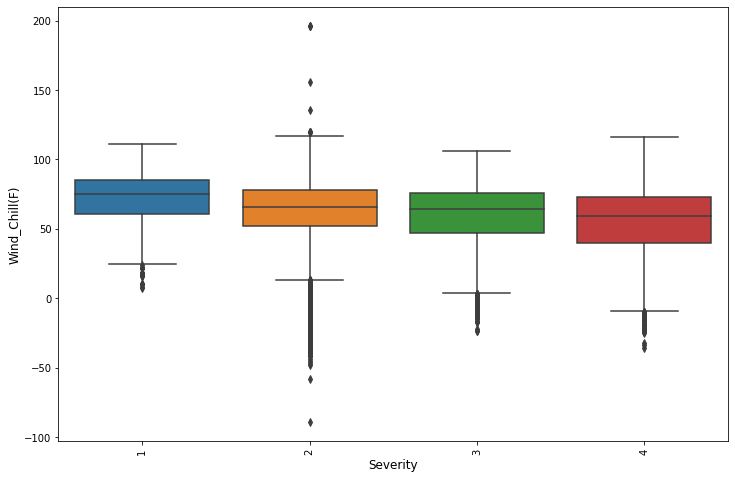

In [80]:
#box plot for mean and quartile distribution
plt.figure(figsize=(12,8))
sns.boxplot(x="Severity", y="Wind_Chill(F)", data=accidents)
plt.ylabel('Wind_Chill(F)', fontsize=12)
plt.xlabel('Severity', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

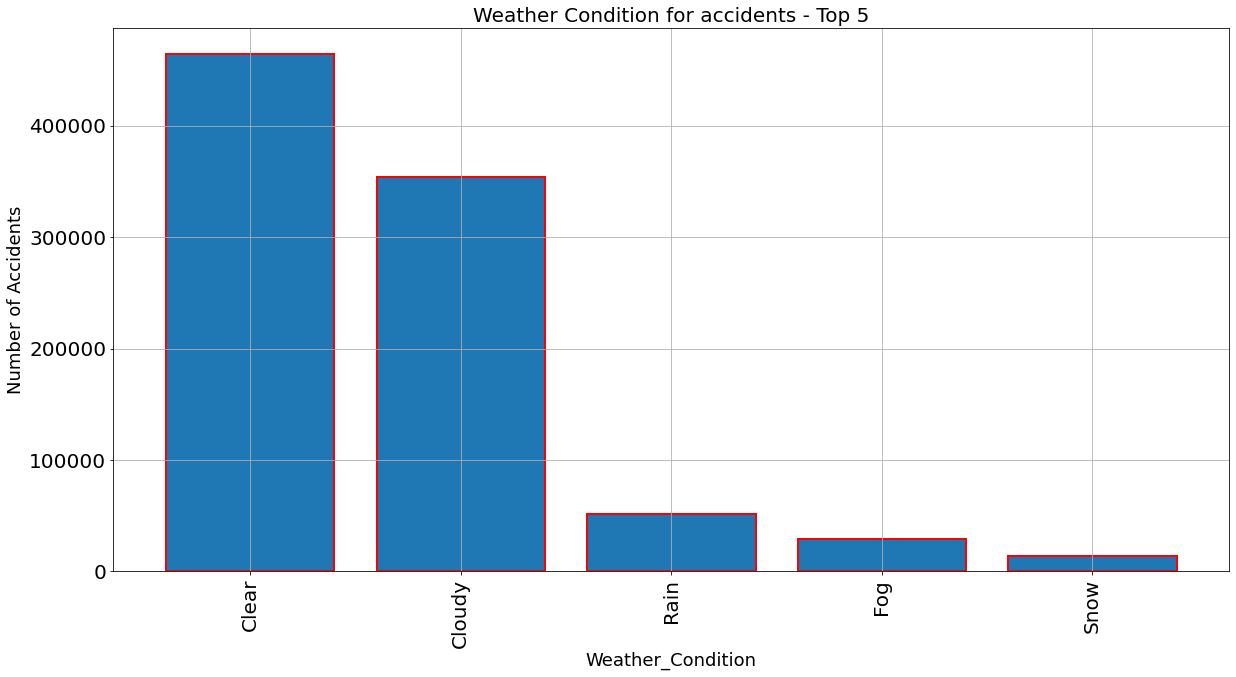

In [52]:
#Plot for Weather condition
fig, ax=plt.subplots(figsize=(20,10))
accidents['Weather_Condition'].value_counts().sort_values(ascending=False).head(5).plot.bar(width=0.8,edgecolor='red',align='center',linewidth=2)
plt.xlabel('Weather_Condition',fontsize=18)
plt.ylabel('Number of Accidents',fontsize=18)
ax.tick_params(labelsize=20)
plt.title('Weather Condition for accidents - Top 5',fontsize=20)
plt.grid()
plt.ioff()

In [53]:
accidents["Weather_Condition"].value_counts()

Clear           464517
Cloudy          354056
Rain             51934
Fog              29374
Snow             13981
Thunderstorm     13154
Windy             8426
Smoke             2997
Sand                85
Hail                16
Name: Weather_Condition, dtype: int64

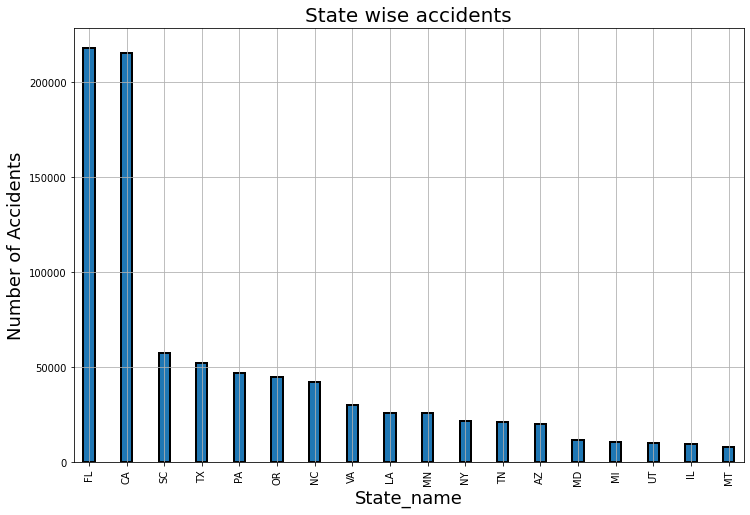

In [81]:
#bar plot for state wise number of accidents
plt.figure(figsize=(12,8))
accidents.State.value_counts().sort_values(ascending=False).head(18).plot.bar(width=0.3,edgecolor='k',align='center',linewidth=2)
plt.xlabel('State_name',fontsize=18)
plt.ylabel('Number of Accidents',fontsize=18)
ax.tick_params(labelsize=20)
plt.title('State wise accidents',fontsize=20)
plt.grid()
plt.ioff()

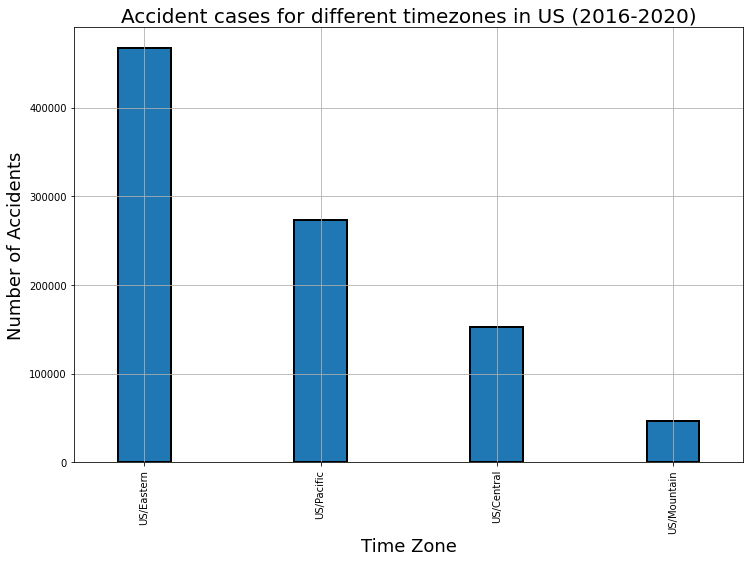

In [82]:
#bar plot for timezone vs number of accidents
plt.figure(figsize=(12,8))
accidents.Timezone.value_counts().sort_values(ascending=False).head(18).plot.bar(width=0.3,edgecolor='k',align='center',linewidth=2)
plt.xlabel('Time Zone',fontsize=18)
plt.ylabel('Number of Accidents',fontsize=18)
ax.tick_params(labelsize=30)
plt.title('Accident cases for different timezones in US (2016-2020)',fontsize=20)
plt.grid()
plt.ioff()

<Figure size 864x576 with 0 Axes>

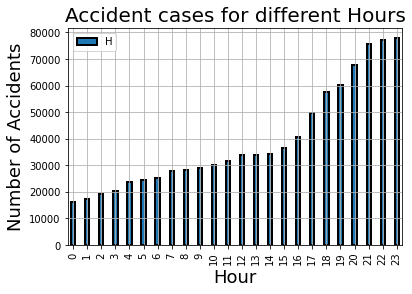

In [56]:
#hour wise plot wrt accidents
plt.figure(figsize=(12,8))
accidents.H.value_counts().sort_values(ascending=True).head(24).reset_index().plot.bar(width=0.3,edgecolor='k',align='center',linewidth=2)
plt.xlabel('Hour',fontsize=18)
plt.ylabel('Number of Accidents',fontsize=18)
ax.tick_params(labelsize=30)
plt.title('Accident cases for different Hours',fontsize=20)
plt.grid()
plt.ioff()

In [83]:
#Correlation matrix

import matplotlib.pyplot as plt

corr = accidents.corr()
corr.style.background_gradient(cmap='YlOrRd')

/opt/conda/lib/python3.7/site-packages/pandas/io/formats/style.py:2813: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/opt/conda/lib/python3.7/site-packages/pandas/io/formats/style.py:2814: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,Severity,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Number,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in),Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop
Severity,1.000000,0.127293,0.084458,0.127295,0.084466,0.126151,0.000828,-0.072404,-0.075263,0.038281,-0.031730,-0.020618,0.008451,0.006882,-0.003327,-0.003858,-0.041902,0.005519,0.020612,-0.008108,-0.004373,-0.001757,-0.019022,0.002387,-0.003548,-0.002725,nan
Start_Lat,0.127293,1.000000,-0.340203,0.999999,-0.340199,0.113744,0.089581,-0.512368,-0.515889,-0.029742,-0.378164,-0.109806,-0.044893,-0.020475,0.003974,-0.001397,-0.090952,0.018299,0.030360,-0.019652,0.007769,-0.006047,-0.149175,0.038528,-0.003034,-0.000343,nan
Start_Lng,0.084458,-0.340203,1.000000,-0.340210,1.000000,-0.039531,-0.162151,0.123254,0.110725,0.165036,0.282325,0.077389,0.088345,0.028183,0.010351,-0.021885,0.054976,0.011107,-0.003880,0.002330,-0.020922,0.001933,0.058251,-0.081567,-0.015853,0.035568,nan
End_Lat,0.127295,0.999999,-0.340210,1.000000,-0.340206,0.113829,0.089578,-0.512375,-0.515897,-0.029741,-0.378169,-0.109806,-0.044900,-0.020480,0.003967,-0.001398,-0.090973,0.018291,0.030361,-0.019654,0.007768,-0.006047,-0.149185,0.038534,-0.003035,-0.000356,nan
End_Lng,0.084466,-0.340199,1.000000,-0.340206,1.000000,-0.039436,-0.162150,0.123254,0.110725,0.165036,0.282333,0.077387,0.088344,0.028184,0.010351,-0.021884,0.054972,0.011110,-0.003879,0.002329,-0.020922,0.001933,0.058249,-0.081568,-0.015853,0.035565,nan
Distance(mi),0.126151,0.113744,-0.039531,0.113829,-0.039436,1.000000,0.070031,-0.065966,-0.069886,0.007194,-0.091021,-0.027817,0.010046,0.001383,-0.020878,-0.004275,-0.051477,0.003069,0.006916,-0.005932,-0.006074,-0.001807,-0.032206,0.006409,-0.005320,-0.056744,nan
Number,0.000828,0.089581,-0.162151,0.089578,-0.162150,0.070031,1.000000,-0.044871,-0.046232,0.009974,-0.066815,-0.016399,0.013244,-0.000036,-0.029976,-0.003765,-0.049916,-0.003465,-0.006986,-0.004591,-0.012289,-0.001013,-0.025716,-0.003219,-0.005072,-0.052413,nan
Temperature(F),-0.072404,-0.512368,0.123254,-0.512375,0.123254,-0.065966,-0.044871,1.000000,0.994628,-0.356174,0.194901,0.215649,0.146374,-0.000079,0.010887,0.005572,0.078062,-0.013893,-0.017496,0.014911,-0.000133,0.002620,0.091786,-0.015032,0.006531,0.018644,nan
Wind_Chill(F),-0.075263,-0.515889,0.110725,-0.515897,0.110725,-0.069886,-0.046232,0.994628,1.000000,-0.342340,0.205354,0.216089,0.100359,-0.000643,0.011506,0.005815,0.076876,-0.014119,-0.017730,0.014571,0.000729,0.002640,0.090468,-0.013695,0.006860,0.018530,nan
Humidity(%),0.038281,-0.029742,0.165036,-0.029741,0.165036,0.007194,0.009974,-0.356174,-0.342340,1.000000,0.192404,-0.337401,-0.196375,0.106630,-0.007745,-0.014067,-0.040745,0.000060,0.000515,-0.011666,-0.000167,0.001785,0.001509,-0.022073,-0.011928,-0.046121,nan


<AxesSubplot:>

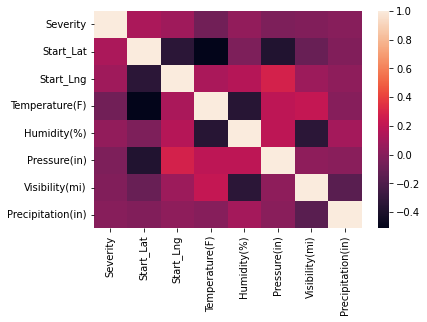

In [64]:
sns.heatmap(accidents[['Severity','Start_Lat','Start_Lng','Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)','Precipitation(in)','Weather_Condition']].corr())

In [58]:
day = pd.DataFrame(accidents.D.value_counts()).reset_index().rename(columns={'index':'Day', 'Start_Time':'Cases'})

In [59]:
day

,Day,D
0,5,161873
1,3,147705
2,4,147651
3,2,141658
4,1,133464
5,6,117005
6,0,89184


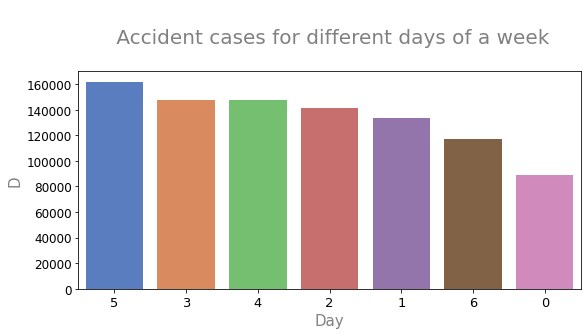

In [84]:
#Week wise vs number of accidents
plt.figure(figsize=(9,4))
plt.title('\n Accident cases for different days of a week\n', size=20, color='grey')
plt.xlabel('\n Day \n', fontsize=15, color='grey')
plt.ylabel('\nAccident Cases\n', fontsize=15, color='grey')
plt.xticks(fontsize=13)
plt.yticks(fontsize=12)
a = sns.barplot(x=day.Day,y=day.D,palette="muted")
plt.show()

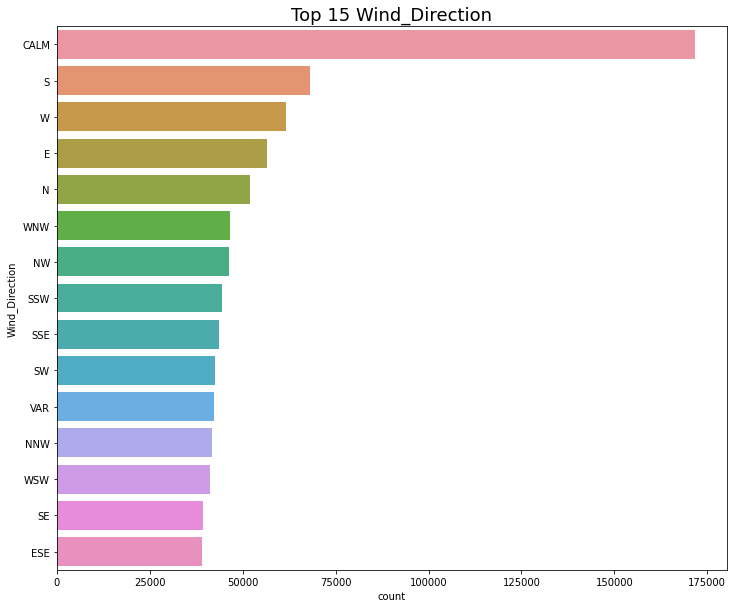

In [69]:
#wind direction vs accidents
fig = plt.figure(figsize = (12, 10))
sns.countplot(y='Wind_Direction', data=accidents, order=accidents['Wind_Direction'].value_counts()[:15].index).set_title("Top 15 Wind_Direction", fontsize = 18)
plt.show()

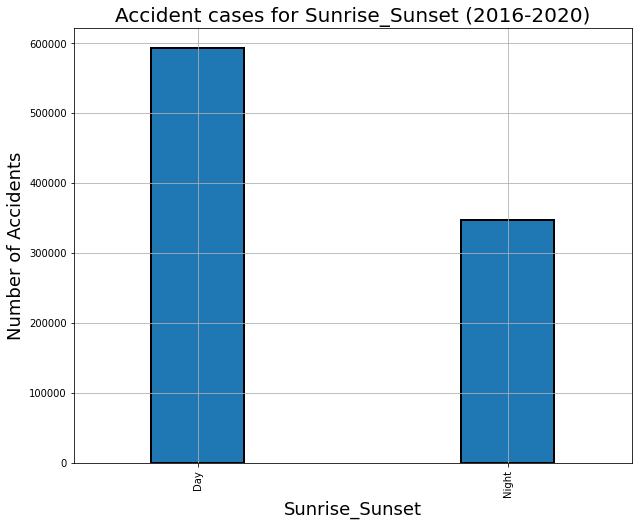

In [86]:
#Sunset Sunrise Day vs Night

plt.figure(figsize=(10,8))
accidents.Sunrise_Sunset.value_counts().sort_values(ascending=False).head(5).plot.bar(width=0.3,edgecolor='k',align='center',linewidth=2)
plt.xlabel('Sunrise_Sunset',fontsize=18)
plt.ylabel('Number of Accidents',fontsize=18)
ax.tick_params(labelsize=30)
plt.title('Accident cases for Sunrise_Sunset (2016-2020)',fontsize=20)
plt.grid()
plt.ioff()

<Figure size 864x576 with 0 Axes>

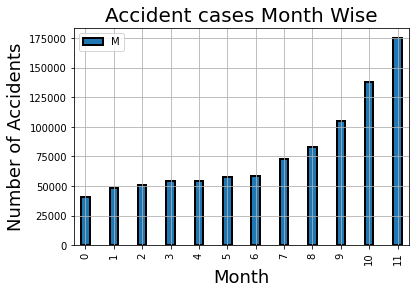

In [88]:
#hour wise plot wrt accidents
plt.figure(figsize=(12,8))
accidents.M.value_counts().sort_values(ascending=True).head(24).reset_index().plot.bar(width=0.3,edgecolor='k',align='center',linewidth=2)
plt.xlabel('Month',fontsize=18)
plt.ylabel('Number of Accidents',fontsize=18)
ax.tick_params(labelsize=30)
plt.title('Accident cases Month Wise',fontsize=20)
plt.grid()
plt.ioff()